<a href="https://colab.research.google.com/github/firdarinoa/bangkit-assignment5/blob/Firda%2FAssignment/LowerBackPain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#import data
dataframe1 = pd.read_csv('Dataset_spine.csv')

# Convert last column to be a table and drop it.
attributes = dataframe1.iloc[5:17]["Unnamed: 13"]
dataframe1.drop(["Unnamed: 13"], axis=1,inplace=True)

#convert label data (class_att)
#dataframe1.Class_att = [1 if i =="Abnormal" else 0 for i in dataframe1.Class_att]

In [58]:
dataframe1.rename(columns = {
    "Col1" : "pelvic_incidence", 
    "Col2" : "pelvic_tilt",
    "Col3" : "lumbar_lordosis_angle",
    "Col4" : "sacral_slope", 
    "Col5" : "pelvic_radius",
    "Col6" : "degree_spondylolisthesis", 
    "Col7" : "pelvic_slope",
    "Col8" : "direct_tilt",
    "Col9" : "thoracic_slope", 
    "Col10" :"cervical_tilt", 
    "Col11" : "sacrum_angle",
    "Col12" : "scoliosis_slope", 
    "Class_att" : "Class_att"}, inplace=True)

dataframe1

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,0.129744,7.8433,14.7484,8.51707,-15.728927,11.5472,Normal
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,0.047913,19.1986,18.1972,7.08745,6.013843,43.8693,Normal
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,0.081070,16.2059,13.5565,8.89572,3.564463,18.4151,Normal
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,0.159251,14.7334,16.0928,9.75922,5.767308,33.7192,Normal


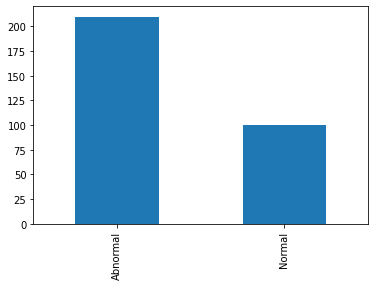

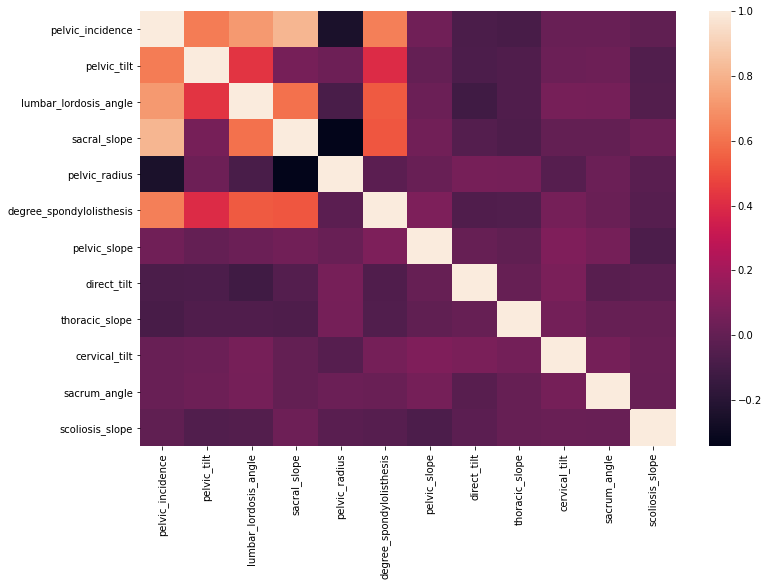

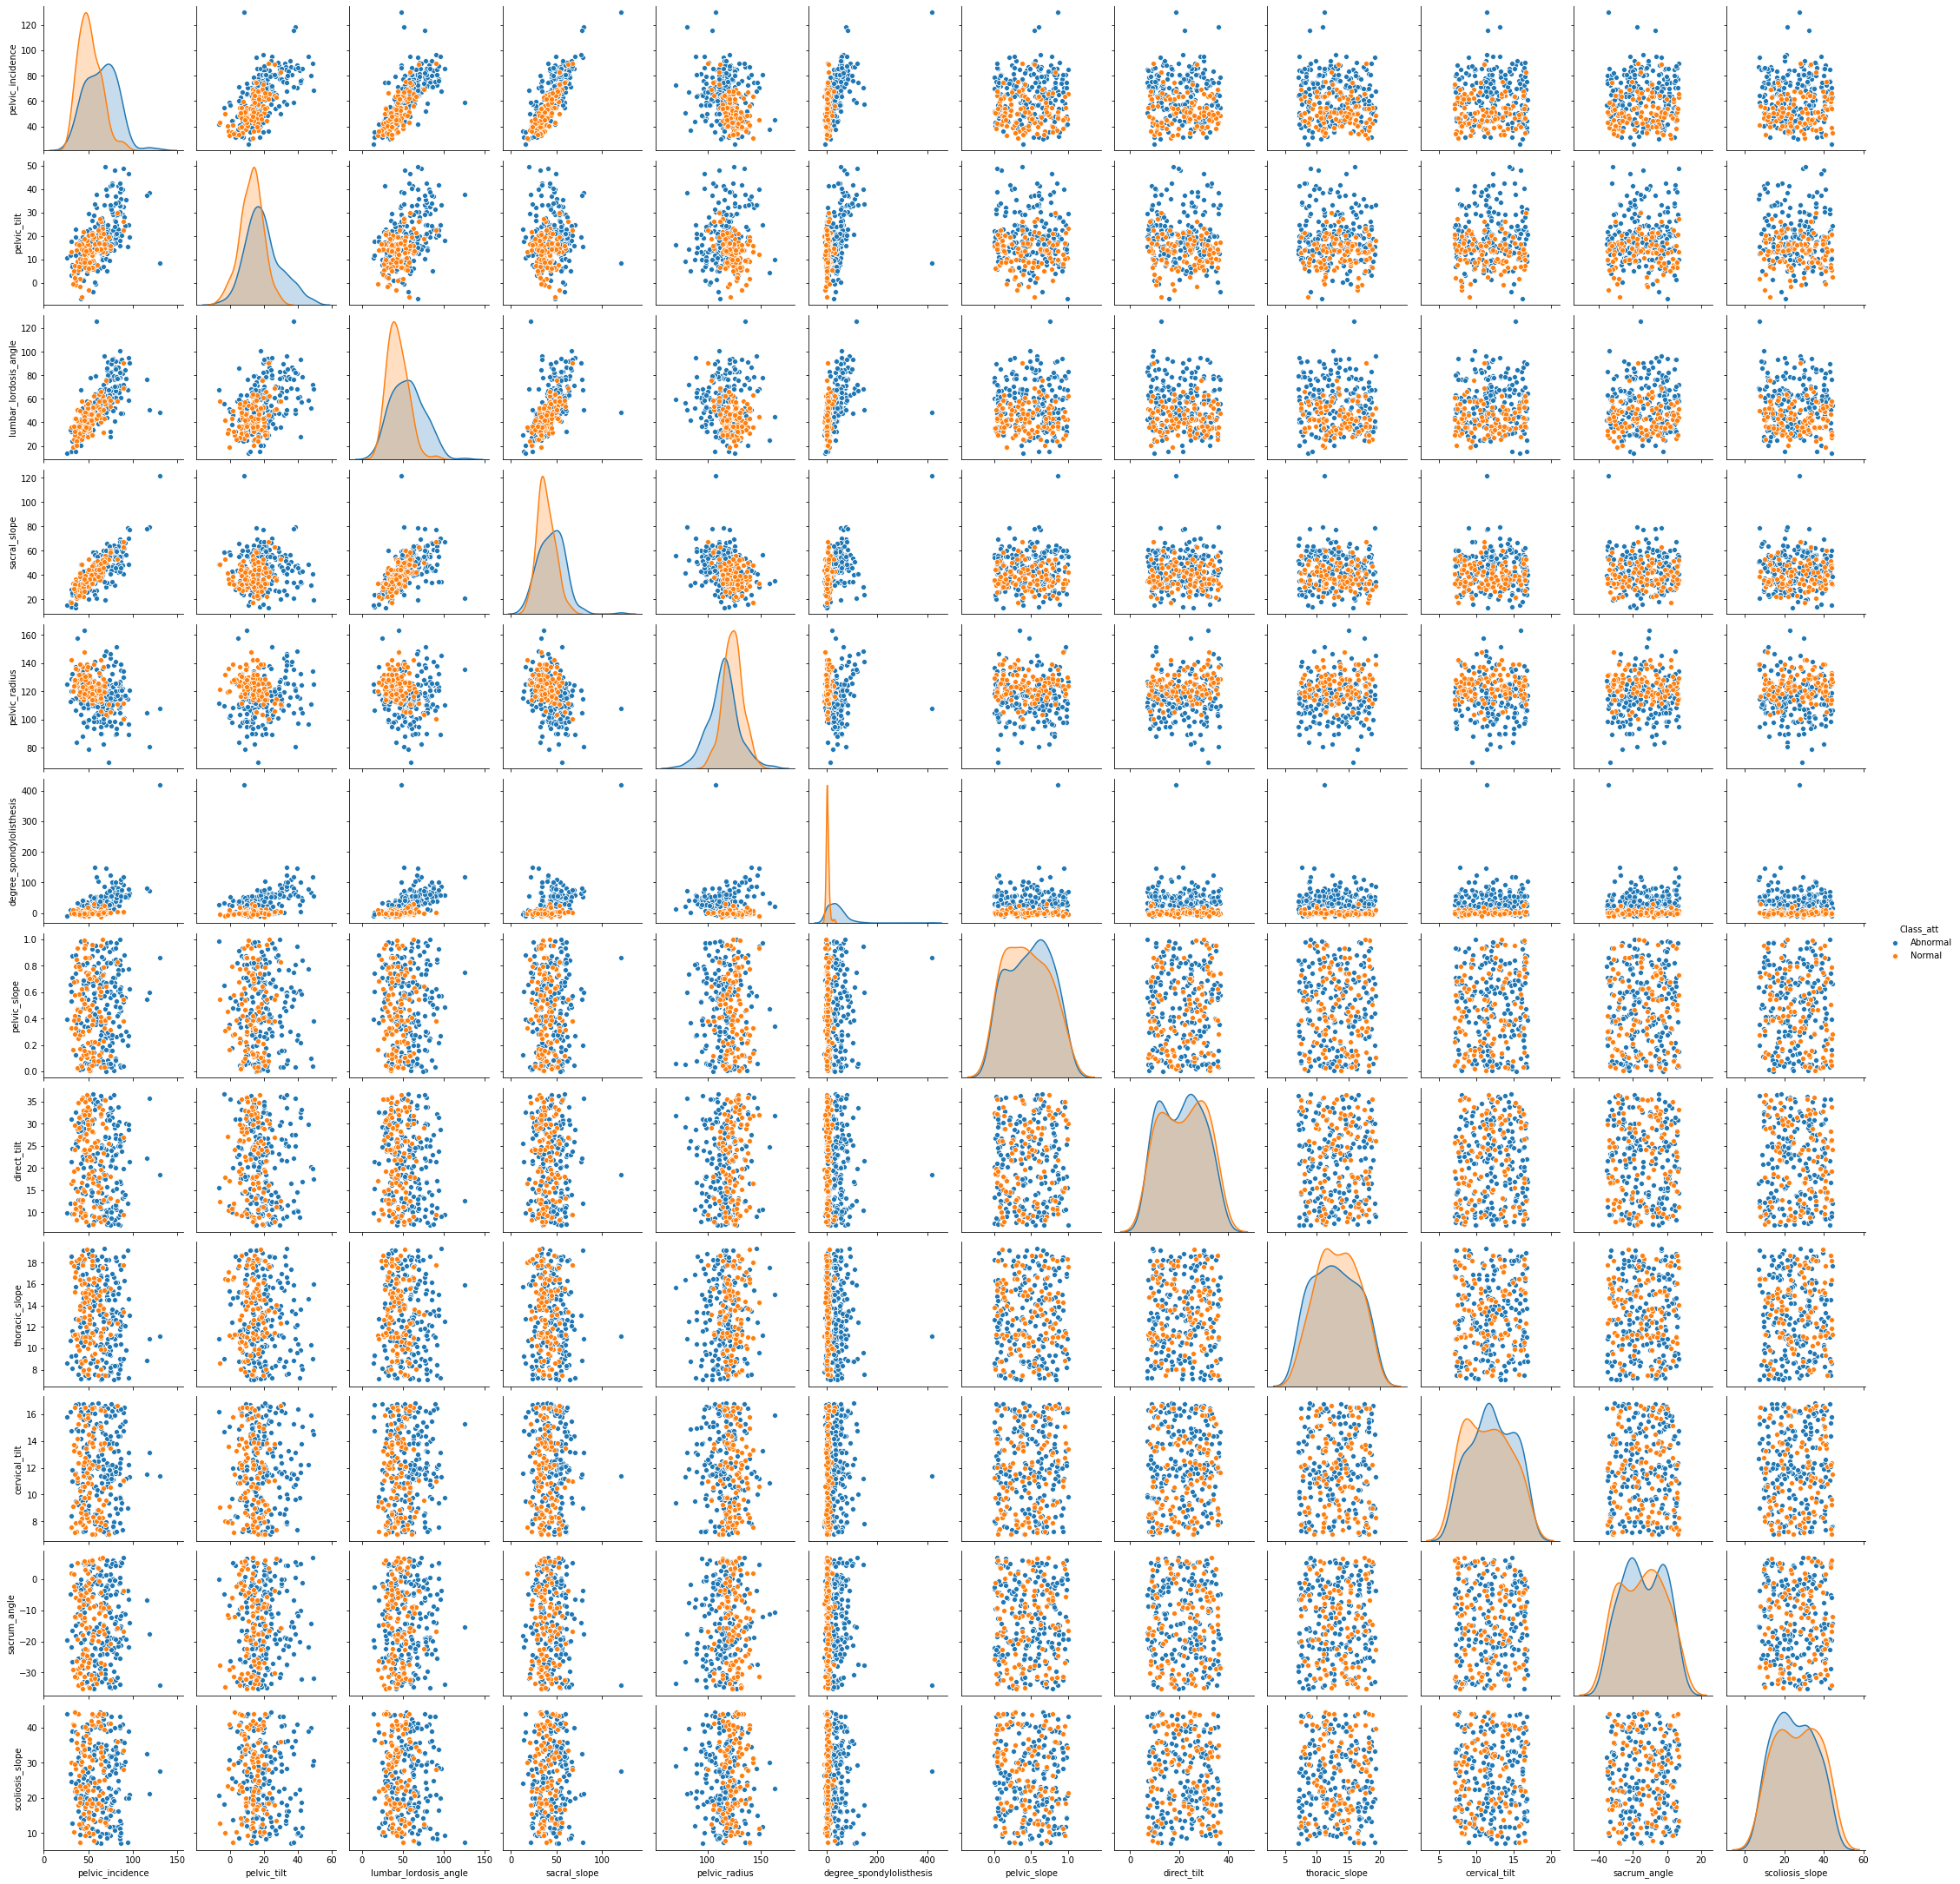

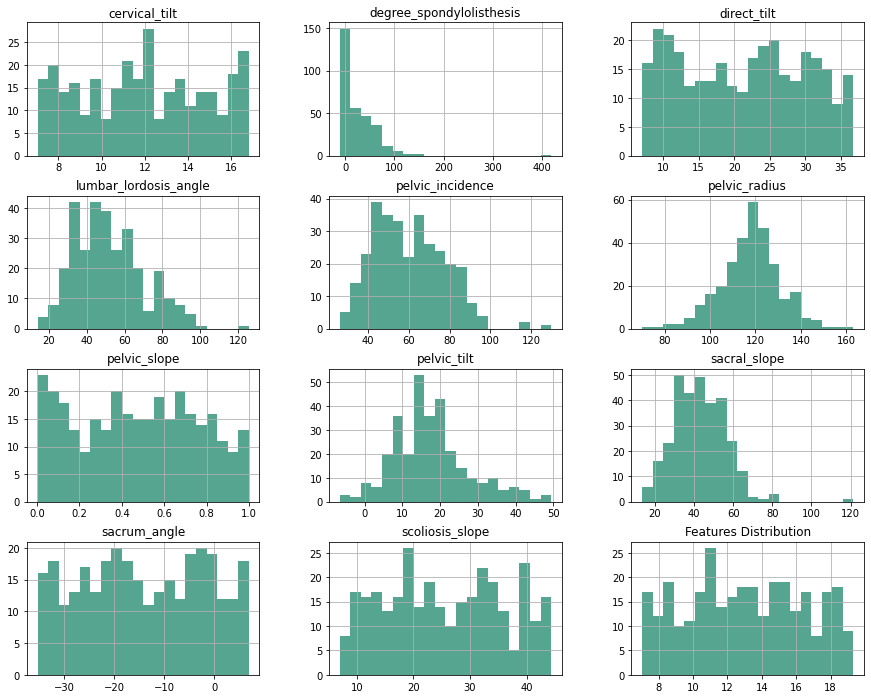

In [64]:
dataframe1["Class_att"].value_counts().sort_index().plot.bar()

plt.subplots(figsize=(12,8))
sns.heatmap(dataframe1.corr())

sns.pairplot(dataframe1, hue="Class_att")

dataframe1.hist(figsize=(15,12),bins = 20, color="#007959AA")
plt.title("Features Distribution")
plt.show()


In [50]:
k=len(dataframe1.Class_att)
i=0
for j in range(len(dataframe1.Class_att)):
    if dataframe1.Class_att[j]==1:
        i+=1
print("Amount of Data     :", k)
print("Amount of Abnormal :", i)
print("Amount of Normal   :", (k-i))

Amount of Data     : 310
Amount of Abnormal : 210
Amount of Normal   : 100


In [33]:
dataframe1_mean = dataframe1.mean()
dataframe1_std = dataframe1.std()
dataframe = (dataframe1-dataframe1_mean)/dataframe1_std

for i in range(len(dataframe)):
    if dataframe.Class_att[i]>=0:
        dataframe.Class_att[i]=1
    elif dataframe.Class_att[i]<0:
        dataframe.Class_att[i]=0

dataframe

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,0.146849,0.500559,-0.664103,-0.184652,-1.445310,-0.706916,0.950094,-1.013427,0.433592,1.165245,-1.194656,1.709604,1.0
1,-1.243853,-0.747560,-1.450655,-1.039839,-0.263958,-0.578621,-0.202226,-0.976237,1.314166,1.676840,-0.938807,-0.912466,1.0
2,0.483588,0.467177,-0.099102,0.272642,-0.896237,-0.794137,0.006683,0.638095,1.300577,1.633329,-1.225197,-0.614693,1.0
3,0.510564,0.710414,-0.410675,0.125925,-1.205354,-0.401639,-0.362627,0.259135,-0.105042,-0.175873,-1.342849,-0.651935,1.0
4,-0.625636,-0.788418,-1.272687,-0.215527,-0.732271,-0.489315,0.246272,1.640442,0.850098,-1.057956,-0.190194,-0.069746,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,-0.730605,-0.392287,-0.858622,-0.645674,-0.035412,-0.813176,-1.201019,-1.560084,0.495303,-1.180758,-0.137072,-1.349094,0.0
306,-0.380582,0.317603,-1.224012,-0.725509,-0.266930,-0.711352,-1.487353,-0.245725,1.509742,-1.674878,1.641393,1.743765,0.0
307,0.055112,0.514786,-0.310475,-0.313057,0.581952,-0.772240,-1.371333,-0.592126,0.144715,-1.049885,1.441044,-0.691913,0.0
308,-0.884393,-0.884230,-0.557711,-0.476358,0.046945,-0.694425,-1.097772,-0.762565,0.890748,-0.751434,1.621227,0.772516,0.0


In [0]:
# split data jadi train, validation, and split
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [0]:
#create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Class_att')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  return ds

In [0]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False)
test_ds = df_to_dataset(test, shuffle=False)

In [0]:
feature = ['Col1','Col2','Col3','Col4','Col5','Col6']
feature_columns = []
for i in feature:
    feature_columns.append(feature_column.numeric_column(i))
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [38]:
#@title 
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Implement L2 regularization in the first hidden layer.
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.04),
                                  name='Hidden1'))
  
  # Implement L2 regularization in the second hidden layer.
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.04),
                                  name='Hidden2'))
    
  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


In [39]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


Epoch 1/100
20/20 [==============================] - 0s 3ms/step - loss: 1.6224 - accuracy: 0.3990
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 1.4730 - accuracy: 0.4545
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 1.3618 - accuracy: 0.5101
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 1.2632 - accuracy: 0.5505
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 1.1757 - accuracy: 0.5909
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 1.0995 - accuracy: 0.6364
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 1.0275 - accuracy: 0.6313
Epoch 8/100
20/20 [==============================] - 0s 3ms/step - loss: 0.9642 - accuracy: 0.6566
Epoch 9/100
20/20 [==============================] - 0s 3ms/step - loss: 0.9056 - accuracy: 0.6919
Epoch 10/100
20/20 [==============================] - 0s 2ms/step - loss: 0.8545 - accuracy: 0.7071
Epoch 11/

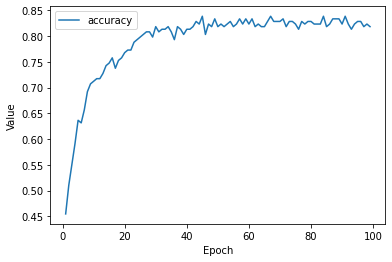

In [40]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 100
batch_size = 10
label_name = "Class_att"
classification_threshold = 0.70

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)